In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

We would like to uncover trends in song / artist popularity using exploratory data analysis techniques with the  Billboard “The Hot 100” dataset. Specifically, we will identify: 
<li>What are the most popular songs?
<li>Who are the top singers?
<li>How has the popularity changed over time?
<li>The relationship between weeks on board and the popularity of artists


# Data Preprocessing

Import the data

In [3]:
charts = pd.read_csv('datasets/charts.csv') 
charts.head()

,rank,song,artist,last-week,peak-rank,weeks-on-board,date
0,1,Butter,BTS,1.0,1,7,2021-07-17
1,2,Good 4 U,Olivia Rodrigo,2.0,1,8,2021-07-17
2,3,Levitating,Dua Lipa Featuring DaBaby,4.0,2,40,2021-07-17
3,4,Kiss Me More,Doja Cat Featuring SZA,3.0,3,13,2021-07-17
4,5,Montero (Call Me By Your Name),Lil Nas X,8.0,1,15,2021-07-17


Check if there's any missing value in the dataframe

In [4]:
charts.isnull().sum()

rank                  0
song                  0
artist                0
last-week         32065
peak-rank             0
weeks-on-board        0
date                  0
dtype: int64

Fortunately there is only 1 column with missing values, however the number of missing values in this column is too large and a simple fill may not be appropriate. We will just drop this column instead. 

In [5]:
charts = charts.drop('last-week',axis=1)

# Data Analysis

What are the most popular songs?

In [6]:
charts[['song','weeks-on-board']].groupby(['song']).max().sort_values(by='weeks-on-board', ascending=False).head(20)

,weeks-on-board
song,
Radioactive,87
Blinding Lights,83
Sail,79
I'm Yours,76
How Do I Live,69
Party Rock Anthem,68
Counting Stars,68
Rolling In The Deep,65
Foolish Games/You Were Meant For Me,65


<AxesSubplot:xlabel='weeks-on-board', ylabel='song'>

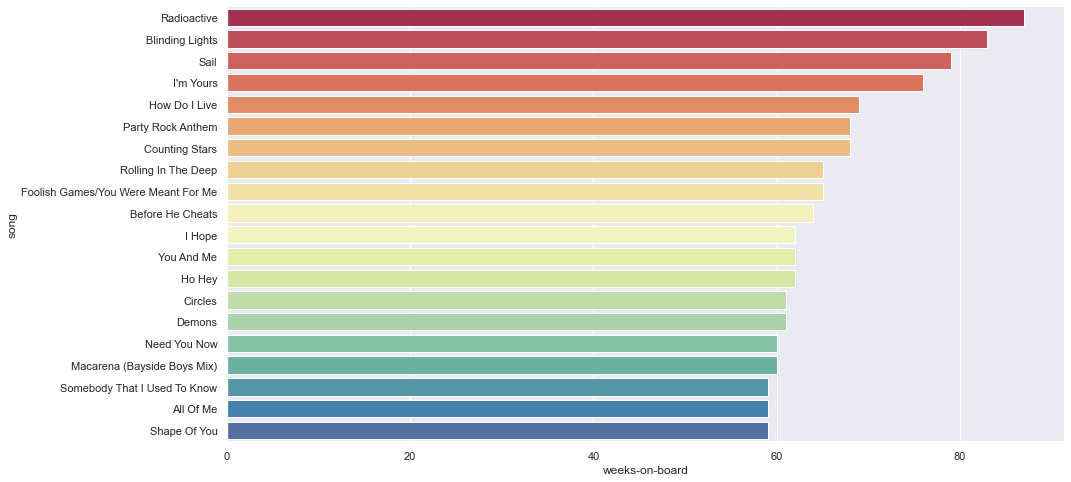

In [7]:
most_popular_song = charts[['song','weeks-on-board']].groupby(['song']).max().sort_values(by='weeks-on-board', ascending=False).head(20)
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(y=most_popular_song.index, x="weeks-on-board", palette="Spectral", orient = "h", data=most_popular_song)

Who are the top singers?

In [8]:
charts['artist'].value_counts(sort=True)[:5]

Taylor Swift     1022
Elton John        889
Madonna           857
Kenny Chesney     758
Drake             751
Name: artist, dtype: int64

/var/folders/v3/2xbz_n0n3rg_gvkjl6tt20qr0000gn/T/ipykernel_18284/1541108848.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  charts["artist"] = charts["artist"].str.replace('\$\$','\\$\\$')


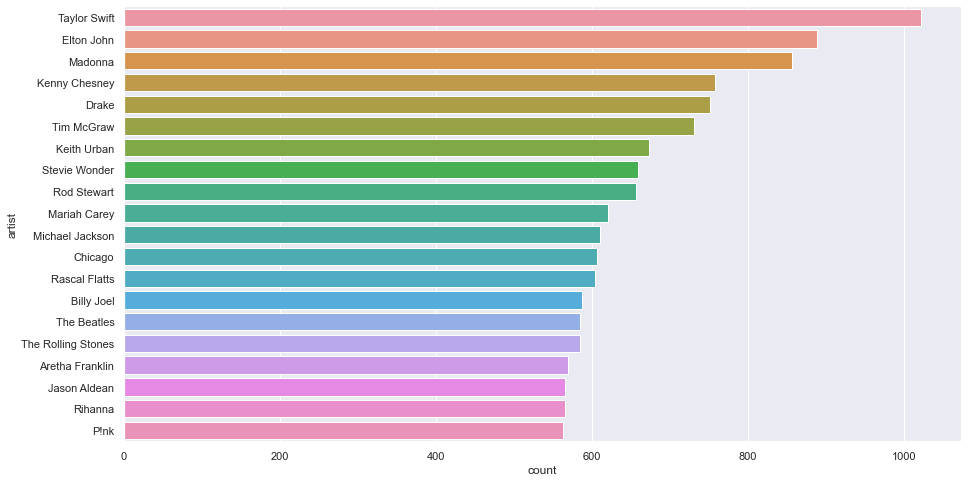

In [9]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
charts["artist"] = charts["artist"].str.replace('\$\$','\\$\\$')
ax = sns.countplot(y="artist", data=charts, order=charts.artist.value_counts().iloc[:20].index)

Most frequent artist... But is that true?

In [10]:
# Uncomment and run following line if needed
# ! pip install nltk
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

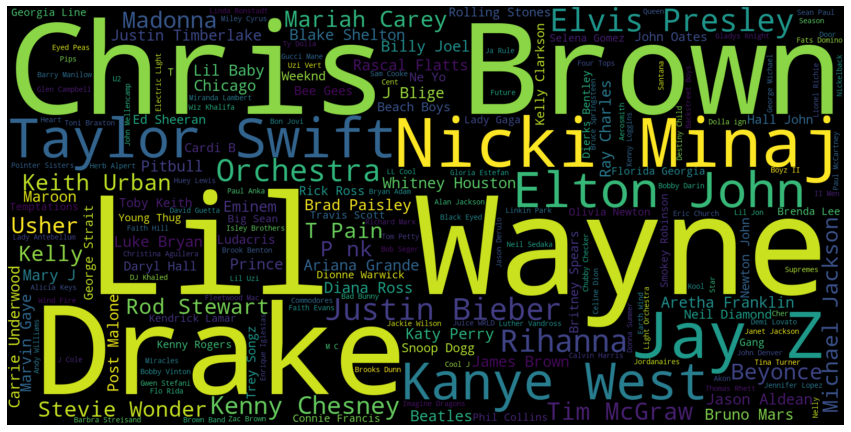

In [11]:
stop_words = ["Featuring", 'X','&',"+"] + list(STOPWORDS)
wordcloud2 = WordCloud(stopwords=stop_words,width=1600, height=800).generate(' '.join(charts['artist'].tolist()))
# Display the generated image:
plt.imshow(wordcloud2,interpolation='bilinear')
plt.axis("off")
plt.show()

In fact, there are lots of song have multiple artist showing as "Maroon 5 Featuring Megan Thee Stallion", "J. Cole & Lil Baby", "Marshmello X Jonas Brothers", etc which are not counting to the frequency of value_count.
Word cloud shows differences.

How has the popularity changed over time?

In [92]:
# sns.lineplot(data=charts, x='date', y='rank', hue='artist')
artists = ['Ed Sheeran', 'Drake']
top_songs = charts[(charts['artist'] == artists[0]) | (charts['artist'] == artists[1])]
top_songs_A = pd.DataFrame(top_songs[top_songs['artist'] == artists[0]].groupby('song').agg({'weeks-on-board':np.mean})).sort_values(by='weeks-on-board',ascending=False)[:5]
top_songs_B = pd.DataFrame(top_songs[top_songs['artist'] == artists[1]].groupby('song').agg({'weeks-on-board':np.mean})).sort_values(by='weeks-on-board',ascending=False)[:5]
top_songs = top_songs[(top_songs['song'].isin(top_songs_A.index)) | (top_songs['song'].isin(top_songs_B.index))]
top_songs

,rank,song,artist,peak-rank,weeks-on-board,date
14520,21,Perfect,Ed Sheeran,1,57,2018-10-06
14544,45,God's Plan,Drake,1,36,2018-10-06
14622,23,Perfect,Ed Sheeran,1,56,2018-09-29
14639,40,God's Plan,Drake,1,35,2018-09-29
14721,22,Perfect,Ed Sheeran,1,55,2018-09-22
...,...,...,...,...,...,...
51224,25,Headlines,Drake,13,5,2011-09-24
51328,29,Headlines,Drake,13,4,2011-09-17
51427,28,Headlines,Drake,13,3,2011-09-10
51520,21,Headlines,Drake,13,2,2011-09-03


<AxesSubplot:xlabel='date', ylabel='rank'>

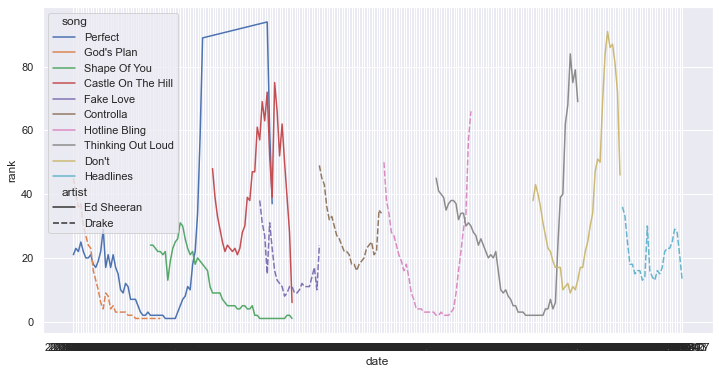

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=top_songs, x='date', y='rank', hue='song', style='artist')


The above graph shows the popularity (position on Billboard) of the top 5 songs from two different artists. 

The relationship between weeks on board and the popularity of artists

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
pop_of_artists=charts.groupby('artist').agg({'song':np.count_nonzero,'weeks-on-board':np.average})
pop_of_artists=pop_of_artists.sort_values(by=['song'],ascending=False)
pop_of_artists=pop_of_artists.rename(columns={'song':'songs_on_board'})
pop_of_artists

,songs_on_board,weeks-on-board
artist,,
Taylor Swift,1022,13.393346
Elton John,889,9.184477
Madonna,857,9.791132
Kenny Chesney,758,9.478892
Drake,751,9.552597
...,...,...
Ray And Bob,1,1.000000
Tory Lanez Featuring Chris Brown,1,1.000000
Tory Lanez Featuring Snoop Dogg,1,1.000000


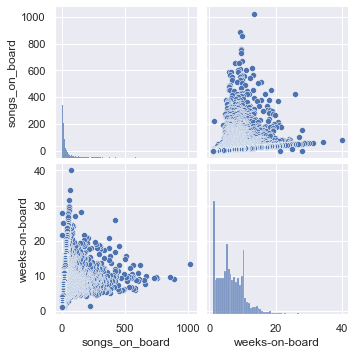

In [15]:
sns.pairplot(pop_of_artists) 

In [16]:
model = smf.ols('Q("songs_on_board") ~ Q("weeks-on-board")', data=pop_of_artists).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Q("songs_on_board")   R-squared:                       0.101
Model:                             OLS   Adj. R-squared:                  0.101
Method:                  Least Squares   F-statistic:                     1136.
Date:                 Fri, 12 Nov 2021   Prob (F-statistic):          5.08e-236
Time:                         01:07:16   Log-Likelihood:                -55648.
No. Observations:                10100   AIC:                         1.113e+05
Df Residuals:                    10098   BIC:                         1.113e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.6533      1.092      1.514      0.130      -0.488       3.794
Q("weeks-on-board")     4.7234      0.140     33.699      0.000       4.449       4.998
==============================================================================
Omnibus:                    10964.830   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882017.707
Skew:                           5.567   Prob(JB):                         0.00
Kurtosis:                      47.406   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The adjusted R-squre is 0.101, which means only 10.1% of the data could be explained by the linear model. The regression is also statistically significant because the P-value is lower than 0.01. These data indicates little relationship between the a singler's songs on board and his/her song's average weak on board.

# Conclusion